In [37]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr
import os
import sys

# 检查并安装 pykrige
try:
    from pykrige.ok import OrdinaryKriging
except ModuleNotFoundError:
    print("正在安装 pykrige...")
    !pip install pykrige
    from pykrige.ok import OrdinaryKriging
    print("pykrige 安装完成")

# 读取CSV文件
light_data_path = '/content/2024年光强_最新整理.csv'  # 光照强度数据文件路径
species_data_path = '/content/2024年物种_最新整理.csv'  # 物种分布数据文件路径

# 其余代码保持不变...


# 读取光照强度数据
print("正在读取光照强度数据...")
light_df = pd.read_csv(light_data_path)

# 读取物种分布数据
print("正在读取物种分布数据...")
species_df = pd.read_csv(species_data_path)

# 显示数据基本信息
print("\n光照强度数据概览:")
print(f"数据点数量: {len(light_df)}")
print(f"数据列: {light_df.columns.tolist()}")
print(light_df.head())

print("\n物种分布数据概览:")
print(f"数据点数量: {len(species_df)}")
print(f"数据列: {species_df.columns.tolist()}")
print(species_df.head())


正在读取光照强度数据...
正在读取物种分布数据...

光照强度数据概览:
数据点数量: 95
数据列: ['location', 'month', 'nsb', 'latitude', 'longitude']
                  location  month       nsb   latitude  longitude
0  Fanling Kau Yan College      1  9.164330  22.488409  114.13849
1  Fanling Kau Yan College      2  8.737287  22.488409  114.13849
2  Fanling Kau Yan College      3  8.372526  22.488409  114.13849
3  Fanling Kau Yan College      4  8.136759  22.488409  114.13849
4  Fanling Kau Yan College      5  7.646656  22.488409  114.13849

物种分布数据概览:
数据点数量: 13875
数据列: ['scientific', 'month', 'gno', 'count', 'OBJECTID', 'longitude', 'latitude']
         scientific  month     gno  count OBJECTID   longitude   latitude
0  Abisara echerius      1  1575.0      1   [4609]  114.145139  22.391244
1  Abisara echerius      1  1575.0      1   [4609]  114.145141  22.382214
2  Abisara echerius      1  1575.0      1   [4609]  114.154851  22.382215
3  Abisara echerius      1  1575.0      1   [4609]  114.154850  22.391246
4  Abisara echerius 

In [38]:
# 确保数据包含必要的列
# 根据实际数据调整列名
required_light_columns = ['longitude', 'latitude', 'nsb', 'month']  # 添加月份
required_species_columns = ['longitude', 'latitude', 'scientific', 'month', 'gno']  # 添加月份和gno

# 检查光照数据列
missing_light_columns = [col for col in required_light_columns if col not in light_df.columns]
if missing_light_columns:
    raise ValueError(f"光照数据缺少必要的列: {missing_light_columns}")

# 检查物种数据列
missing_species_columns = [col for col in required_species_columns if col not in species_df.columns]
if missing_species_columns:
    raise ValueError(f"物种数据缺少必要的列: {missing_species_columns}")

# 打印物种数据中gno列的基本信息
print("\ngno列的数据类型和基本统计信息:")
print(f"数据类型: {species_df['gno'].dtype}")
print(species_df['gno'].describe())

# 按经度、纬度和月份分组，计算每个组内的物种丰富度（不同物种的数量）
print("\n计算每个经纬度和月份组合的物种丰富度...")
species_richness_by_loc = species_df.groupby(['longitude', 'latitude', 'month'])['scientific'].nunique().reset_index()
species_richness_by_loc.rename(columns={'scientific': 'species_count'}, inplace=True)

# 同时处理gno数据
# 根据gno的性质选择合适的聚合方法
# 如果gno是分类变量，可以计算唯一值数量或使用众数
# 如果gno是数值变量，可以计算平均值、总和或其他统计量

# 计算每个位置-月份组合的gno平均值（假设gno是数值型）
gno_by_loc = species_df.groupby(['longitude', 'latitude', 'month'])['gno'].agg(['mean', 'median', 'count']).reset_index()
gno_by_loc.rename(columns={'mean': 'gno_mean', 'median': 'gno_median', 'count': 'gno_count'}, inplace=True)

print("\n按经纬度和月份计算的gno统计结果:")
print(f"位置-月份组合数量: {len(gno_by_loc)}")
print(gno_by_loc.head())

# 将物种丰富度和gno数据合并
species_data_combined = pd.merge(
    species_richness_by_loc,
    gno_by_loc,
    on=['longitude', 'latitude', 'month'],
    how='outer'
)

print("\n合并后的物种丰富度和gno结果:")
print(f"记录数量: {len(species_data_combined)}")
print(species_data_combined.head())

# 保存中间结果，方便后续分析
species_data_combined.to_csv('species_data_with_gno.csv', index=False)
print("已保存合并后的物种数据到 'species_data_with_gno.csv'")



gno列的数据类型和基本统计信息:
数据类型: float64
count    13875.000000
mean      1264.741982
std        639.634304
min        249.000000
25%        930.000000
50%        931.000000
75%       1504.000000
max       3407.000000
Name: gno, dtype: float64

计算每个经纬度和月份组合的物种丰富度...

按经纬度和月份计算的gno统计结果:
位置-月份组合数量: 1023
    longitude   latitude  month     gno_mean  gno_median  gno_count
0  113.834809  22.219306      3  2873.000000      2873.0         16
1  113.834831  22.210276      3  2873.000000      2873.0          8
2  113.844487  22.228357      3  2804.000000      2804.0         22
3  113.844508  22.219326      3  2833.052632      2804.0         19
4  113.844529  22.210296      3  2929.052632      2944.0         38

合并后的物种丰富度和gno结果:
记录数量: 1023
    longitude   latitude  month  species_count     gno_mean  gno_median  \
0  113.834809  22.219306      3              8  2873.000000      2873.0   
1  113.834831  22.210276      3              8  2873.000000      2873.0   
2  113.844487  22.228357      3             

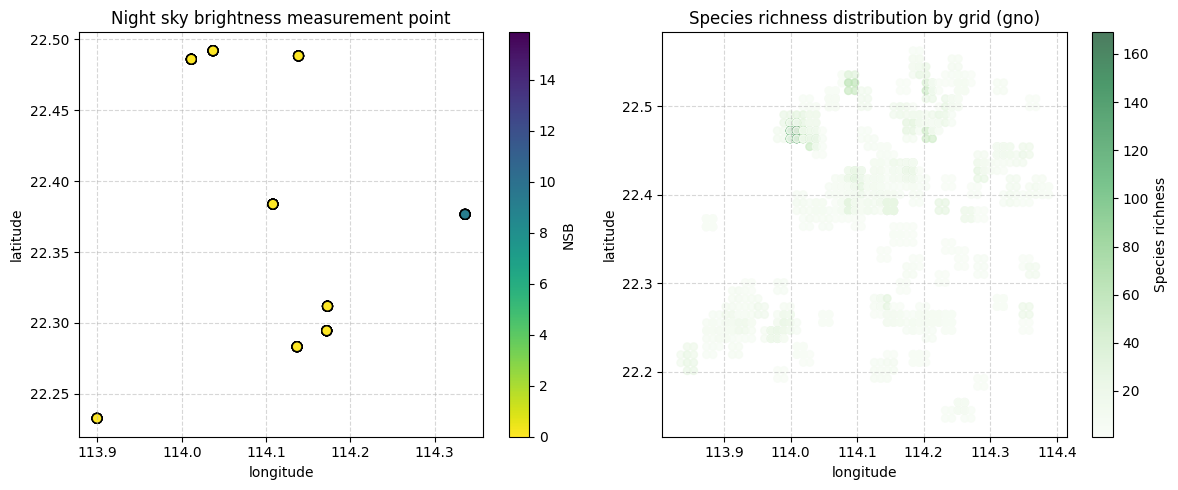

In [39]:
# 可视化原始数据点
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.scatter(light_df['longitude'], light_df['latitude'], c=light_df['nsb'],
            cmap='viridis_r', s=50, edgecolor='k')
plt.colorbar(label='NSB')
plt.title('Night sky brightness measurement point')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.grid(True, linestyle='--', alpha=0.5)

plt.subplot(122)
plt.scatter(species_richness_by_loc['longitude'], species_richness_by_loc['latitude'],
            c=species_richness_by_loc['species_count'], cmap='Greens', s=30, alpha=0.7)

plt.colorbar(label='Species richness')
plt.title('Species richness distribution by grid (gno)')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [40]:
# 确保数据中没有缺失值
light_df_clean = light_df.dropna(subset=['longitude', 'latitude', 'nsb'])
species_richness_by_loc = species_richness_by_loc.dropna()

# 打印清洗后的数据信息
print(f"\n清洗后的光照数据点数: {len(light_df_clean)}")
print(f"清洗后的物种丰富度数据点数: {len(species_richness_by_loc)}")

# 提取坐标和夜空亮度值
x = light_df_clean['longitude'].values
y = light_df_clean['latitude'].values
z = light_df_clean['nsb'].values

print(f"用于克里金插值的数据点数: {len(x)}")

# 定义网格范围
grid_space = 0.01  # 网格间距，根据你的数据范围调整
grid_x = np.arange(np.min(x) - 0.05, np.max(x) + 0.05, grid_space)
grid_y = np.arange(np.min(y) - 0.05, np.max(y) + 0.05, grid_space)

print(f"插值网格大小: {len(grid_x)}x{len(grid_y)}")



清洗后的光照数据点数: 95
清洗后的物种丰富度数据点数: 1023
用于克里金插值的数据点数: 95
插值网格大小: 54x36


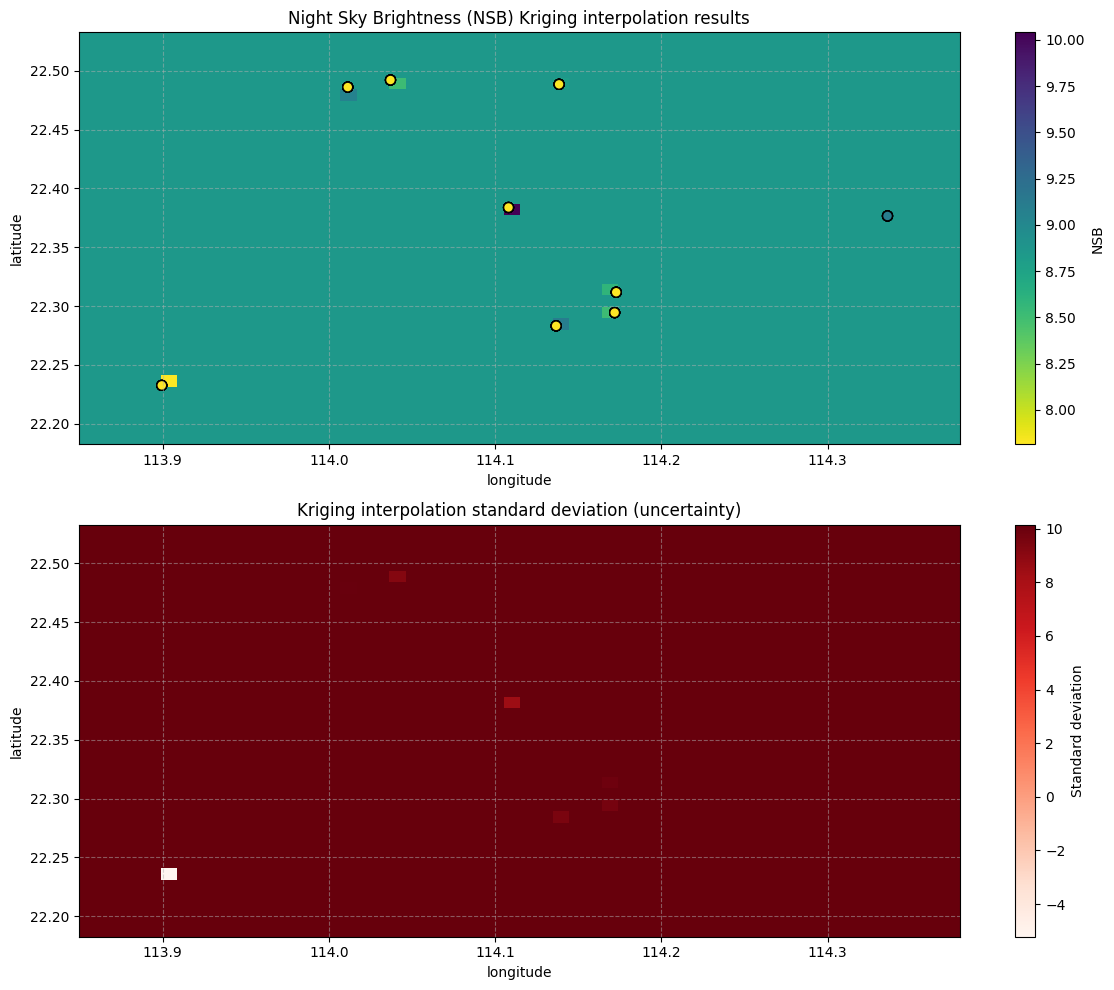

克里金插值完成


In [41]:
# 创建克里金模型
OK = OrdinaryKriging(
    x, y, z,
    variogram_model='spherical',  # 可以尝试不同的变异函数模型
    verbose=False,
    enable_plotting=False
)

# 执行插值
z_interpolated, ss = OK.execute('grid', grid_x, grid_y)

# 可视化插值结果
plt.figure(figsize=(12, 10))

# 创建自定义的颜色映射，从暗到亮
cmap = plt.cm.viridis_r  # 反转的viridis色彩映射，较暗的区域表示较低的光污染

# 绘制插值结果
plt.subplot(211)
plt.title('Night Sky Brightness (NSB) Kriging interpolation results')
im = plt.imshow(z_interpolated, origin='lower',
                extent=(np.min(grid_x), np.max(grid_x), np.min(grid_y), np.max(grid_y)),
                aspect='auto', cmap=cmap)
plt.scatter(x, y, c=z, cmap=cmap, edgecolor='k', s=50, marker='o')
plt.colorbar(im, label='NSB')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.grid(True, linestyle='--', alpha=0.5)

# 绘制标准差/不确定性
plt.subplot(212)
plt.title('Kriging interpolation standard deviation (uncertainty)')
im2 = plt.imshow(ss, origin='lower',
                extent=(np.min(grid_x), np.max(grid_x), np.min(grid_y), np.max(grid_y)),
                aspect='auto', cmap='Reds')
plt.colorbar(im2, label='Standard deviation')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print("克里金插值完成")


In [42]:
# 将插值结果转换为数据框，以便后续分析
# 创建网格点坐标
xx, yy = np.meshgrid(grid_x, grid_y)

# 将网格点坐标和插值结果展平
interpolated_df = pd.DataFrame({
    'longitude': xx.flatten(),
    'latitude': yy.flatten(),
    'nsb_interpolated': z_interpolated.flatten(),
    'nsb_std': ss.flatten()  # 插值的标准差
})

print("\n插值结果数据框前5行:")
print(interpolated_df.head())

# 使用之前创建的species_richness_by_loc变量，而不是未定义的species_richness
# 确保数据中没有缺失值
species_richness_by_loc = species_richness_by_loc.dropna()

print(f"\n清洗后的物种丰富度数据点数: {len(species_richness_by_loc)}")

# 现在可以将物种分布数据与插值后的光照强度数据合并
# 对于物种分布的每个位置，找到最近的插值点
from scipy.spatial import cKDTree

# 创建KD树
tree = cKDTree(interpolated_df[['longitude', 'latitude']].values)

# 为物种丰富度数据中的每个点找到最近的插值点
distances, indices = tree.query(species_richness_by_loc[['longitude', 'latitude']].values)

# 将插值的NSB值添加到物种丰富度数据中
species_richness_by_loc['nsb_interpolated'] = interpolated_df.iloc[indices]['nsb_interpolated'].values
species_richness_by_loc['nsb_std'] = interpolated_df.iloc[indices]['nsb_std'].values

print("\n添加插值NSB后的物种丰富度数据前5行:")
print(species_richness_by_loc.head())



插值结果数据框前5行:
    longitude   latitude  nsb_interpolated    nsb_std
0  113.849496  22.182602          8.849679  10.145548
1  113.859496  22.182602          8.849679  10.145548
2  113.869496  22.182602          8.849679  10.145548
3  113.879496  22.182602          8.849679  10.145548
4  113.889496  22.182602          8.849679  10.145548

清洗后的物种丰富度数据点数: 1023

添加插值NSB后的物种丰富度数据前5行:
    longitude   latitude  month  species_count  nsb_interpolated    nsb_std
0  113.834809  22.219306      3              8          8.849679  10.145548
1  113.834831  22.210276      3              8          8.849679  10.145548
2  113.844487  22.228357      3             11          8.849679  10.145548
3  113.844508  22.219326      3             17          8.849679  10.145548
4  113.844529  22.210296      3             18          8.849679  10.145548


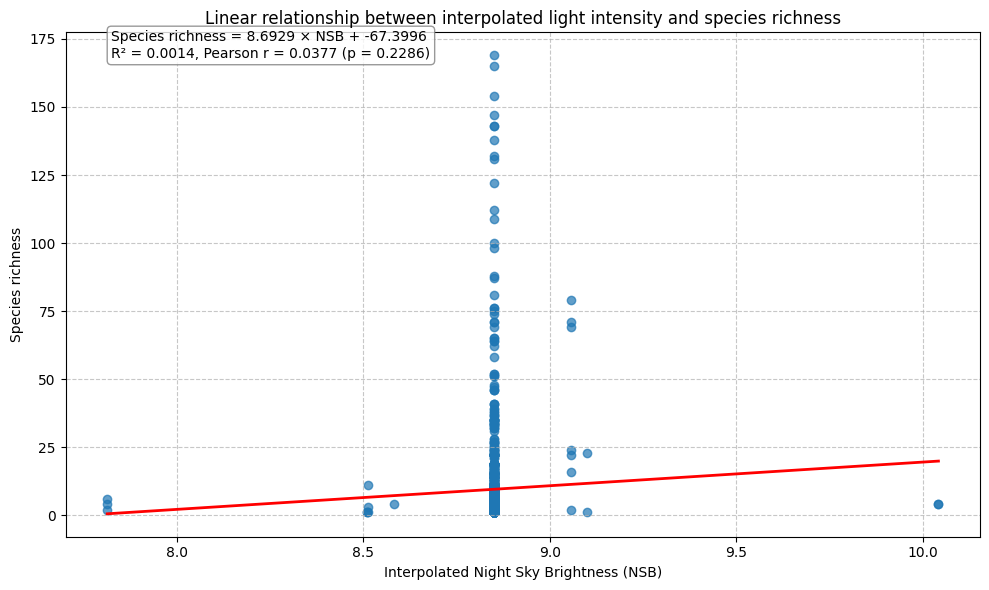


--- 基于插值数据的线性回归分析结果 ---
回归方程: Species richness = 8.6929 × NSB + -67.3996
决定系数 (R²): 0.0014
均方误差 (MSE): 370.3505
Pearson相关系数: 0.0377 (p = 0.2286)


In [43]:
# 分析光强与物种丰富度的关系
# 线性回归分析
X = species_richness_by_loc[['nsb_interpolated']].values  # 确保X是二维数组
y = species_richness_by_loc['species_count'].values

model = LinearRegression()
model.fit(X, y)

# 预测值
y_pred = model.predict(X)

# 评估模型
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
coef = model.coef_[0]
intercept = model.intercept_

# 计算Pearson相关系数
pearson_corr, p_value = pearsonr(species_richness_by_loc['nsb_interpolated'], species_richness_by_loc['species_count'])

# 可视化结果
plt.figure(figsize=(10, 6))
plt.scatter(species_richness_by_loc['nsb_interpolated'], species_richness_by_loc['species_count'], alpha=0.7)

# 创建排序后的X值用于绘制回归线
X_sorted = np.sort(species_richness_by_loc['nsb_interpolated'].values)
X_sorted_2d = X_sorted.reshape(-1, 1)  # 确保是二维数组
y_pred_sorted = model.predict(X_sorted_2d)

plt.plot(X_sorted, y_pred_sorted, color='red', linewidth=2)
plt.xlabel('Interpolated Night Sky Brightness (NSB)')
plt.ylabel('Species richness')
plt.title('Linear relationship between interpolated light intensity and species richness')
plt.grid(True, linestyle='--', alpha=0.7)

# 添加回归方程和统计信息
equation = f'Species richness = {coef:.4f} × NSB + {intercept:.4f}'
stats = f'R² = {r2:.4f}, Pearson r = {pearson_corr:.4f} (p = {p_value:.4f})'
plt.annotate(equation + '\n' + stats, xy=(0.05, 0.95), xycoords='axes fraction',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.show()

# 打印详细结果
print("\n--- 基于插值数据的线性回归分析结果 ---")
print(f"回归方程: {equation}")
print(f"决定系数 (R²): {r2:.4f}")
print(f"均方误差 (MSE): {mse:.4f}")
print(f"Pearson相关系数: {pearson_corr:.4f} (p = {p_value:.4f})")


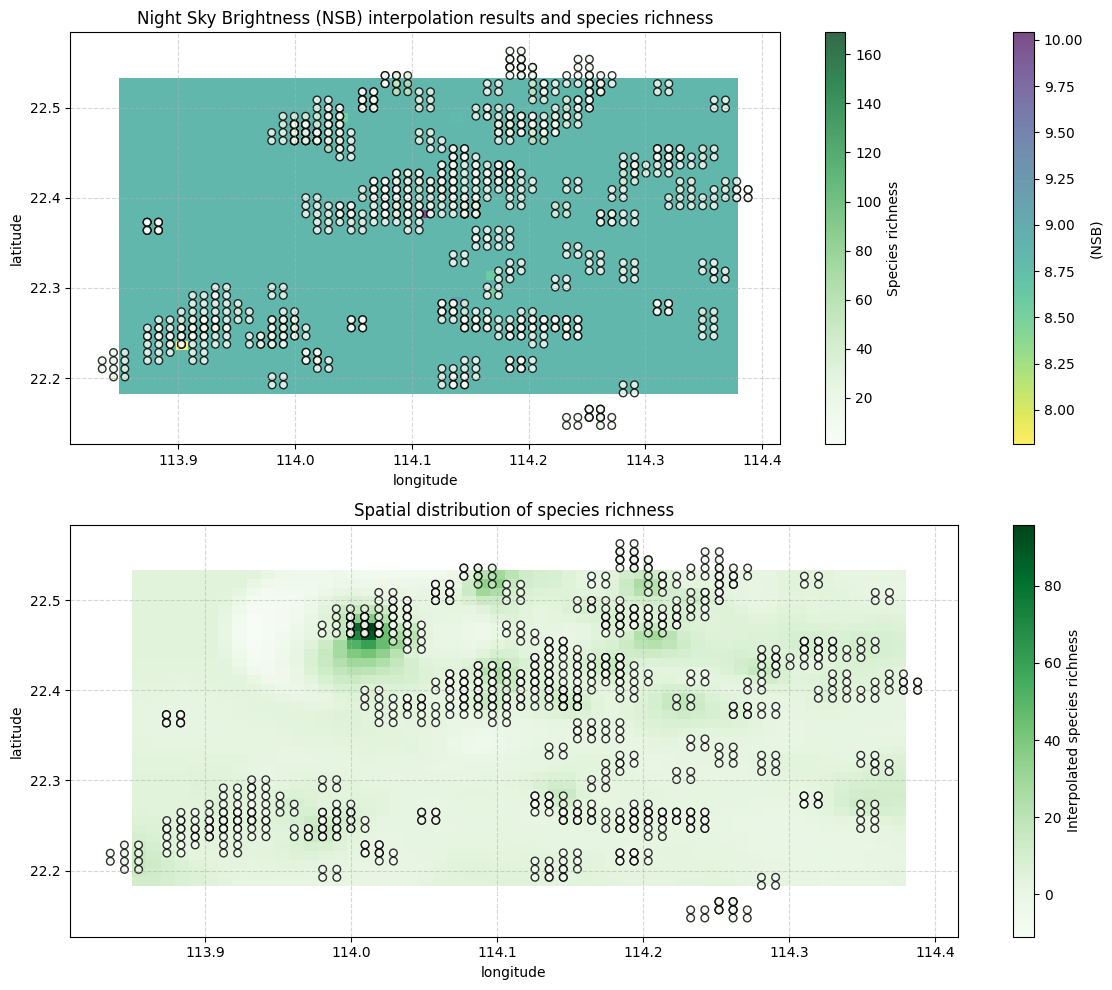

In [44]:
# 可视化物种丰富度与光污染的空间关系
plt.figure(figsize=(12, 10))

# 绘制插值后的光污染地图
plt.subplot(211)
plt.title('Night Sky Brightness (NSB) interpolation results and species richness')
im = plt.imshow(z_interpolated, origin='lower',
                extent=(np.min(grid_x), np.max(grid_x), np.min(grid_y), np.max(grid_y)),
                aspect='auto', cmap=cmap, alpha=0.7)
plt.colorbar(im, label='(NSB)')

# 叠加物种丰富度点
sc = plt.scatter(species_richness_by_loc['longitude'], species_richness_by_loc['latitude'],
                c=species_richness_by_loc['species_count'], cmap='Greens',
                s=30, edgecolor='k', alpha=0.8)
plt.colorbar(sc, label='Species richness')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.grid(True, linestyle='--', alpha=0.5)

# 绘制物种丰富度的空间分布
plt.subplot(212)
plt.title('Spatial distribution of species richness')

# 创建物种丰富度的插值
species_OK = OrdinaryKriging(
    species_richness_by_loc['longitude'].values,
    species_richness_by_loc['latitude'].values,
    species_richness_by_loc['species_count'].values,
    variogram_model='spherical',
    verbose=False,
    enable_plotting=False
)

species_interpolated, species_ss = species_OK.execute('grid', grid_x, grid_y)

im3 = plt.imshow(species_interpolated, origin='lower',
                extent=(np.min(grid_x), np.max(grid_x), np.min(grid_y), np.max(grid_y)),
                aspect='auto', cmap='Greens')
plt.colorbar(im3, label='Interpolated species richness')
plt.scatter(species_richness_by_loc['longitude'], species_richness_by_loc['latitude'],
            c=species_richness_by_loc['species_count'], cmap='Greens',
            s=30, edgecolor='k', alpha=0.8)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [45]:
# 2. 对光照强度数据进行克里金插值
print("\n正在进行克里金插值...")

# 创建一个函数，对每个月份的数据进行克里金插值
def kriging_by_month(month, light_data, grid_size=200):  # 增加网格密度
    # 筛选特定月份的数据
    month_data = light_data[light_data['month'] == month]

    if len(month_data) < 3:
        print(f"月份 {month} 的数据点不足，无法进行克里金插值")
        return None

    # 提取坐标和nsb值
    lons = month_data['longitude'].values
    lats = month_data['latitude'].values
    nsb_values = month_data['nsb'].values

    # 创建更大范围的网格，确保覆盖所有物种观测点
    # 扩大边界，确保插值覆盖更广的区域
    lon_buffer = 0.2  # 增加经度缓冲区
    lat_buffer = 0.2  # 增加纬度缓冲区
    grid_lon = np.linspace(min(lons) - lon_buffer, max(lons) + lon_buffer, grid_size)
    grid_lat = np.linspace(min(lats) - lat_buffer, max(lats) + lat_buffer, grid_size)

    # 尝试不同的变异函数模型
    variogram_models = ['spherical', 'exponential', 'gaussian', 'linear']
    best_result = None
    best_error = float('inf')

    for model in variogram_models:
        try:
            # 执行普通克里金插值，调整参数以提高稳定性
            OK = OrdinaryKriging(
                lons, lats, nsb_values,
                variogram_model=model,
                verbose=False,
                enable_plotting=False,
                nlags=20,  # 增加变异函数计算的滞后数
                weight=True  # 启用距离权重
            )

            z, ss = OK.execute('grid', grid_lon, grid_lat)

            # 使用交叉验证评估模型质量
            if hasattr(OK, 'get_statistics') and 'rmse' in OK.get_statistics():
                error = OK.get_statistics()['rmse']
            else:
                # 简单估计误差
                error = np.mean(ss)  # 使用估计方差作为误差指标

            if error < best_error:
                best_error = error
                best_result = (z, model)

        except Exception as e:
            print(f"  尝试变异函数模型 {model} 失败: {e}")
            continue

    if best_result is None:
        print(f"月份 {month} 的所有克里金插值模型都失败了")
        return None

    z, best_model = best_result
    print(f"  月份 {month} 使用 {best_model} 变异函数模型")

    # 创建插值结果的数据框 - 使用列表收集数据，然后一次性创建DataFrame
    result_data = []

    for i, lon in enumerate(grid_lon):
        for j, lat in enumerate(grid_lat):
            # 只保留有效的插值结果（非NaN值）
            if not np.isnan(z[j, i]):
                result_data.append({
                    'month': month,
                    'longitude': lon,
                    'latitude': lat,
                    'nsb_interpolated': z[j, i]  # 注意：z的索引是[j,i]而不是[i,j]
                })

    # 一次性创建DataFrame
    result_df = pd.DataFrame(result_data)
    print(f"  月份 {month} 生成了 {len(result_df)} 个插值点")
    return result_df

# 对每个月份进行克里金插值
all_months = light_df['month'].unique()
interpolated_dfs = []

# 如果月份数据太少，可以考虑按季度或半年进行分组
if len(all_months) > 0 and all([len(light_df[light_df['month'] == m]) < 3 for m in all_months]):
    print("各月份数据点太少，尝试按季度分组...")
    # 创建季度映射
    light_df['quarter'] = ((light_df['month'] - 1) // 3) + 1
    quarters = light_df['quarter'].unique()

    for quarter in quarters:
        print(f"处理季度 {quarter}...")
        quarter_months = [m for m in range(1, 13) if ((m - 1) // 3) + 1 == quarter]
        quarter_data = light_df[light_df['month'].isin(quarter_months)]

        # 为季度中的每个月创建插值
        for month in quarter_months:
            if month in all_months:  # 确保这个月有物种数据
                print(f"使用季度 {quarter} 的数据为月份 {month} 插值...")
                # 临时替换月份以便插值
                temp_data = quarter_data.copy()
                temp_data['month'] = month
                result = kriging_by_month(month, temp_data)
                if result is not None:
                    interpolated_dfs.append(result)
else:
    # 正常按月份处理
    for month in all_months:
        print(f"处理月份 {month}...")
        result = kriging_by_month(month, light_df)
        if result is not None:
            interpolated_dfs.append(result)

# 合并所有月份的插值结果
if interpolated_dfs:
    interpolated_light = pd.concat(interpolated_dfs, ignore_index=True)
    print(f"插值后的光照数据点数量: {len(interpolated_light)}")
else:
    print("所有月份的插值都失败了")
    # 如果插值失败，创建一个空的DataFrame
    interpolated_light = pd.DataFrame(columns=['month', 'longitude', 'latitude', 'nsb_interpolated'])



正在进行克里金插值...
处理月份 1...
  月份 1 使用 spherical 变异函数模型
  月份 1 生成了 40000 个插值点
处理月份 2...
  月份 2 使用 spherical 变异函数模型
  月份 2 生成了 40000 个插值点
处理月份 3...
  月份 3 使用 spherical 变异函数模型
  月份 3 生成了 40000 个插值点
处理月份 4...
  月份 4 使用 spherical 变异函数模型
  月份 4 生成了 40000 个插值点
处理月份 5...
  月份 5 使用 spherical 变异函数模型
  月份 5 生成了 40000 个插值点
处理月份 6...
  月份 6 使用 spherical 变异函数模型
  月份 6 生成了 40000 个插值点
处理月份 7...
  月份 7 使用 spherical 变异函数模型
  月份 7 生成了 40000 个插值点
处理月份 8...
  月份 8 使用 spherical 变异函数模型
  月份 8 生成了 40000 个插值点
处理月份 9...
  月份 9 使用 spherical 变异函数模型
  月份 9 生成了 40000 个插值点
处理月份 10...
  月份 10 使用 linear 变异函数模型
  月份 10 生成了 40000 个插值点
处理月份 12...
  尝试变异函数模型 spherical 失败: Each lower bound must be strictly less than each upper bound.
  尝试变异函数模型 exponential 失败: Each lower bound must be strictly less than each upper bound.
  尝试变异函数模型 gaussian 失败: Each lower bound must be strictly less than each upper bound.
  尝试变异函数模型 linear 失败: Each lower bound must be strictly less than each upper bound.
月份 12 的所有克里金插值模型都失败了
插值后的光照数据点数量: 40000

In [46]:
# 3. 为物种数据匹配最近的插值光照强度
print("\n为物种数据匹配最近的光照强度...")
species_grouped=pd.read_csv('/content/species_data_with_gno.csv')
# 创建一个函数，为每个物种观测点找到最近的插值光照点
def find_nearest_light_data(species_row, light_data, max_distance=0.3):  # 增加最大距离参数
    # 筛选同月份的光照数据
    month_light = light_data[light_data['month'] == species_row['month']]

    if len(month_light) == 0:
        # 如果当月没有数据，尝试使用相邻月份的数据
        adjacent_months = []
        if species_row['month'] > 1:
            adjacent_months.append(species_row['month'] - 1)
        if species_row['month'] < 12:
            adjacent_months.append(species_row['month'] + 1)

        month_light = light_data[light_data['month'].isin(adjacent_months)]
        if len(month_light) == 0:
            # 如果相邻月份也没有数据，尝试使用同季度的数据
            quarter = ((species_row['month'] - 1) // 3) + 1
            quarter_months = [m for m in range(1, 13) if ((m - 1) // 3) + 1 == quarter]
            month_light = light_data[light_data['month'].isin(quarter_months)]

            if len(month_light) == 0:
                return None

    # 计算距离（使用哈弗辛公式计算地理距离，单位为km）
    R = 6371  # 地球半径，单位为km

    # 将经纬度转换为弧度
    lon1 = np.radians(species_row['longitude'])
    lat1 = np.radians(species_row['latitude'])
    lon2 = np.radians(month_light['longitude'])
    lat2 = np.radians(month_light['latitude'])

    # 计算经纬度差
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # 哈弗辛公式
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = R * c

    month_light['distance'] = distance

    # 找到最近的点，但要求距离不超过最大阈值
    if month_light['distance'].min() <= max_distance:
        nearest = month_light.loc[month_light['distance'].idxmin()]
        return nearest['nsb_interpolated']
    else:
        # 如果没有足够近的点，尝试增加搜索范围
        if max_distance < 0.5:  # 如果当前阈值小于0.5km
            return find_nearest_light_data(species_row, light_data, max_distance=0.5)
        return None

# 为每个物种观测点匹配光照数据
print("开始匹配光照数据...")
species_grouped['nsb_matched'] = species_grouped.apply(
    lambda row: find_nearest_light_data(row, interpolated_light), axis=1
)

# 显示匹配进度
matched_count = species_grouped['nsb_matched'].notna().sum()
total_count = len(species_grouped)
print(f"匹配进度: {matched_count}/{total_count} ({matched_count/total_count*100:.2f}%)")

# 如果匹配率低于50%，尝试使用更简单的距离计算方法
if matched_count / total_count < 0.5:
    print("匹配率低，尝试使用欧几里得距离进行匹配...")

    def find_nearest_light_data_simple(species_row, light_data, max_distance=0.5):
        # 筛选任何月份的光照数据
        # 计算简单的欧几里得距离
        light_data['distance'] = np.sqrt(
            (light_data['longitude'] - species_row['longitude'])**2 +
            (light_data['latitude'] - species_row['latitude'])**2
        )

        if light_data['distance'].min() <= max_distance:
            nearest = light_data.loc[light_data['distance'].idxmin()]
            return nearest['nsb_interpolated']
        return None

    # 对未匹配的数据点重新尝试匹配
    for idx in species_grouped.index:
        if pd.isna(species_grouped.loc[idx, 'nsb_matched']):
            species_grouped.loc[idx, 'nsb_matched'] = find_nearest_light_data_simple(
                species_grouped.loc[idx], interpolated_light
            )

# 移除没有匹配到光照数据的行
species_with_light = species_grouped.dropna(subset=['nsb_matched'])
print(f"成功匹配光照数据的物种观测点数量: {len(species_with_light)}")
print(f"匹配率: {len(species_with_light)/len(species_grouped)*100:.2f}%")

# 保存匹配结果，包括未匹配的数据点（用于后续分析）
species_grouped.to_csv('species_with_light_all.csv', index=False)
species_with_light.to_csv('species_with_light_matched.csv', index=False)



为物种数据匹配最近的光照强度...
开始匹配光照数据...
匹配进度: 1023/1023 (100.00%)
成功匹配光照数据的物种观测点数量: 1023
匹配率: 100.00%



Column names in species_with_light_and_gno dataframe:
['longitude', 'latitude', 'month', 'species_count', 'gno_mean', 'gno_median', 'gno_count', 'nsb_matched', 'gno_mean_combined', 'gno_median_combined', 'species_count_combined']
Number of data points after merging: 1023

Performing regression analysis...
Regression model results:
Slope (impact of light intensity on gno_mean): -127.4599
Intercept: 2913.1276
R² value: 0.0142
Root Mean Square Error (RMSE): 793.6830
Pearson correlation coefficient: -0.1190 (p-value: 0.0001)
Light intensity has a weak negative correlation with gno_mean, which is statistically significant.


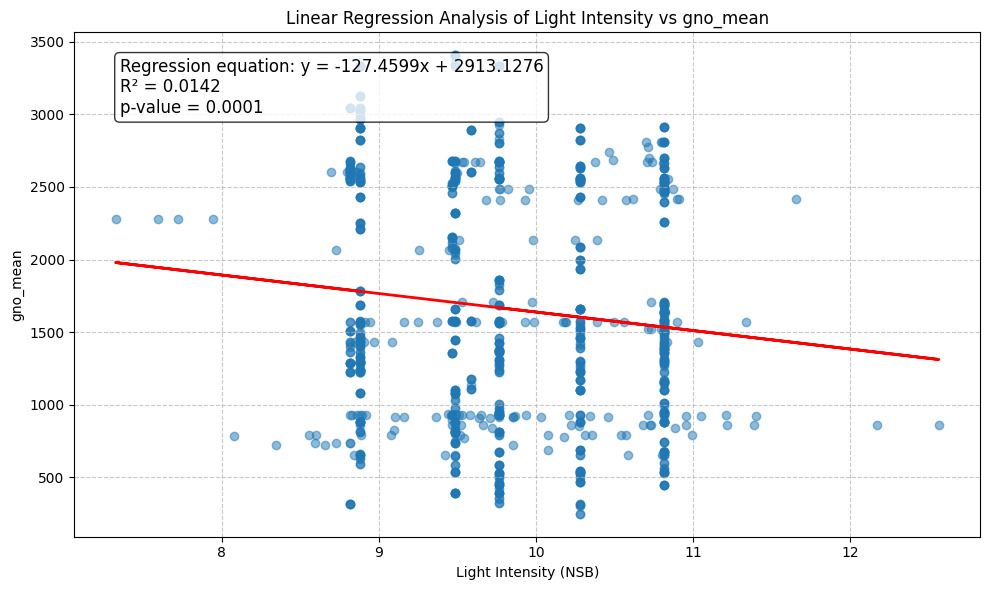

In [47]:
# 合并数据时指定后缀
species_with_light_and_gno = pd.merge(
    species_with_light,
    species_data_combined[['latitude', 'longitude', 'month', 'gno_mean', 'gno_median', 'species_count']],
    on=['latitude', 'longitude', 'month'],
    how='inner',
    suffixes=('', '_combined')  # 自定义后缀
)

# 检查合并后的数据框
print("\nColumn names in species_with_light_and_gno dataframe:")
print(species_with_light_and_gno.columns.tolist())
print(f"Number of data points after merging: {len(species_with_light_and_gno)}")

# 进行回归分析
print("\nPerforming regression analysis...")

# 检查是否有足够的数据点进行回归
if len(species_with_light_and_gno) < 10:
    print("Insufficient data points for meaningful regression analysis")
else:
    # 使用gno_mean作为因变量
    y_column = 'gno_mean'  # 使用未加后缀的列名
    y_description = 'gno_mean'

    # 准备回归数据
    X = species_with_light_and_gno['nsb_matched'].values.reshape(-1, 1)
    y = species_with_light_and_gno[y_column].values

    # 创建并拟合线性回归模型
    model = LinearRegression()
    model.fit(X, y)

    # 预测并计算模型性能指标
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))

    # 计算皮尔逊相关系数
    pearson_corr, p_value = pearsonr(X.flatten(), y)

    # 输出结果
    print(f"Regression model results:")
    print(f"Slope (impact of light intensity on {y_description}): {model.coef_[0]:.4f}")
    print(f"Intercept: {model.intercept_:.4f}")
    print(f"R² value: {r2:.4f}")
    print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
    print(f"Pearson correlation coefficient: {pearson_corr:.4f} (p-value: {p_value:.4f})")

    # 判断相关性强度
    if abs(pearson_corr) < 0.3:
        strength = "weak"
    elif abs(pearson_corr) < 0.7:
        strength = "moderate"
    else:
        strength = "strong"

    direction = "positive" if pearson_corr > 0 else "negative"
    significance = "statistically significant" if p_value < 0.05 else "not statistically significant"

    print(f"Light intensity has a {strength} {direction} correlation with {y_description}, which is {significance}.")

    # 可视化回归结果
    plt.figure(figsize=(10, 6))
    plt.scatter(X, y, alpha=0.5)
    plt.plot(X, y_pred, color='red', linewidth=2)
    plt.title(f'Linear Regression Analysis of Light Intensity vs {y_description}')
    plt.xlabel('Light Intensity (NSB)')
    plt.ylabel(f'{y_description}')
    plt.grid(True, linestyle='--', alpha=0.7)

    # 添加回归方程和R²到图表
    equation = f'y = {model.coef_[0]:.4f}x + {model.intercept_:.4f}'
    plt.text(0.05, 0.95, f'Regression equation: {equation}\nR² = {r2:.4f}\np-value = {p_value:.4f}',
             transform=plt.gca().transAxes, fontsize=12,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()



Generating visualizations...
Columns in species_with_light_and_gno dataframe:
['longitude', 'latitude', 'month', 'species_count', 'gno_mean', 'gno_median', 'gno_count', 'nsb_matched', 'gno_mean_combined', 'gno_median_combined', 'species_count_combined']


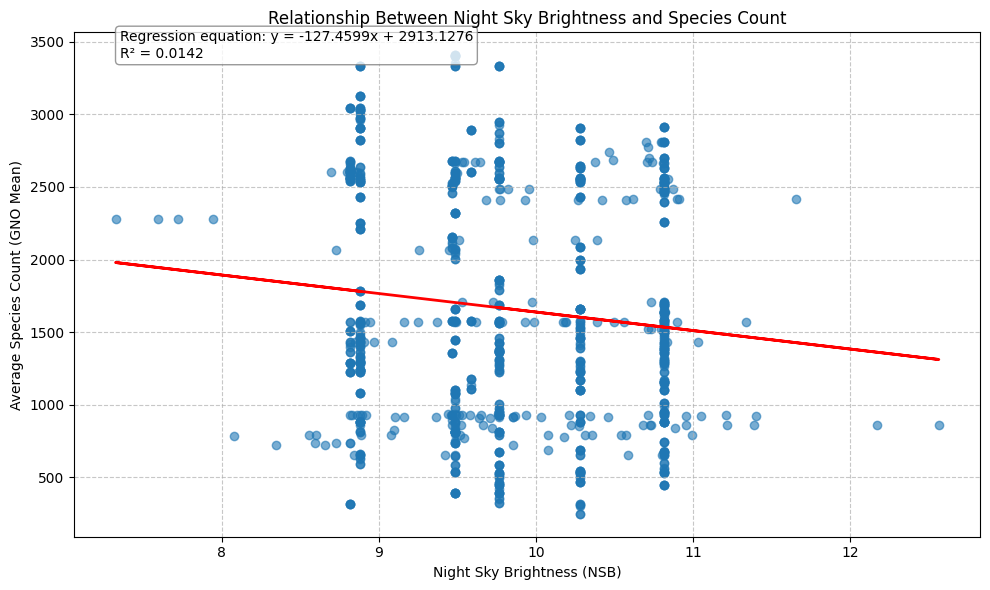

<ipython-input-48-202bc5ba3685>:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([group['gno_mean'].values for _, group in grouped_by_month],


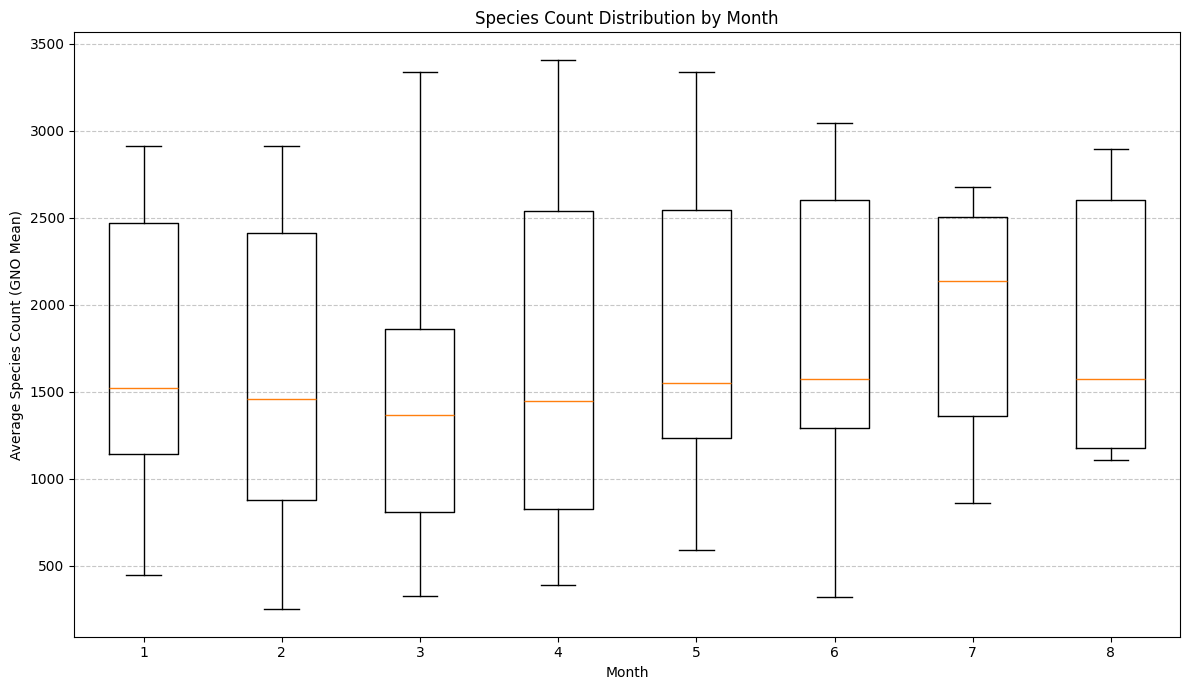

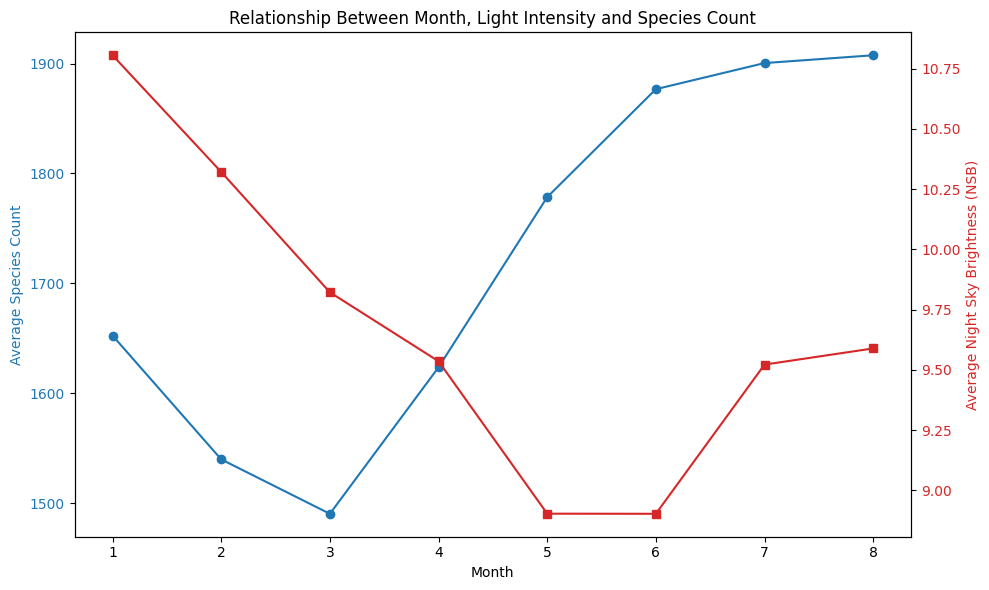

In [48]:
# 5. 可视化结果
print("\nGenerating visualizations...")

# 确认数据框中的列
print("Columns in species_with_light_and_gno dataframe:")
print(species_with_light_and_gno.columns.tolist())

# 散点图：光照强度与物种数量关系
plt.figure(figsize=(10, 6))
plt.scatter(species_with_light_and_gno['nsb_matched'], species_with_light_and_gno['gno_mean'], alpha=0.6)
plt.plot(X, y_pred, color='red', linewidth=2)
plt.xlabel('Night Sky Brightness (NSB)')
plt.ylabel('Average Species Count (GNO Mean)')
plt.title('Relationship Between Night Sky Brightness and Species Count')
plt.grid(True, linestyle='--', alpha=0.7)

# 添加回归方程和R²到图表
equation = f"y = {model.coef_[0]:.4f}x + {model.intercept_:.4f}"
plt.annotate(f"Regression equation: {equation}\nR² = {r2:.4f}",
             xy=(0.05, 0.95), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.savefig('light_species_regression.png')
plt.show()

# 按月份分组的箱线图
plt.figure(figsize=(12, 7))
grouped_by_month = species_with_light_and_gno.groupby('month')

months = []
gno_values = []  # 修正变量名

for month, group in grouped_by_month:
    months.extend([month] * len(group))
    gno_values.extend(group['gno_mean'].values)  # 使用gno_mean而不是gno

plt.boxplot([group['gno_mean'].values for _, group in grouped_by_month],
            labels=sorted(species_with_light_and_gno['month'].unique()))
plt.xlabel('Month')
plt.ylabel('Average Species Count (GNO Mean)')
plt.title('Species Count Distribution by Month')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('species_by_month.png')
plt.show()

# 热力图：月份-光照强度-物种数量
pivot_data = species_with_light_and_gno.pivot_table(
    index='month',
    values=['gno_mean', 'nsb_matched'],  # 使用gno_mean而不是gno
    aggfunc='mean'
).reset_index()

fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Month')
ax1.set_ylabel('Average Species Count', color=color)
ax1.plot(pivot_data['month'], pivot_data['gno_mean'], 'o-', color=color)  # 使用gno_mean
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Average Night Sky Brightness (NSB)', color=color)
ax2.plot(pivot_data['month'], pivot_data['nsb_matched'], 's-', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Relationship Between Month, Light Intensity and Species Count')
fig.tight_layout()
plt.savefig('monthly_trends.png')
plt.show()



Performing regression analysis by month...

Regression analysis results by month:
   month      slope   intercept        r2   pearson       p_value  sample_size
0      1  20.174887 -208.963377  0.056581  0.237867  2.482286e-04          233
1      2  19.525730 -194.445832  0.102299  0.319842  6.612954e-05          150
2      3  19.010730 -172.768466  0.030729  0.175298  2.183122e-02          171
3      4  39.024489 -360.365806  0.155033  0.393742  1.248356e-06          142
4      5  55.301308 -483.717737  0.231578  0.481226  1.571889e-11          175
5      6   3.544744  -25.373411  0.065921  0.256752  1.297940e-02           93
6      7  -3.845631   43.491327  0.030050 -0.173349  2.847477e-01           40
7      8   0.000000    8.684211  0.000000       NaN           NaN           19


<ipython-input-49-45cafa1f0225>:23: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_month, p_value_month = pearsonr(X_month.flatten(), y_month)


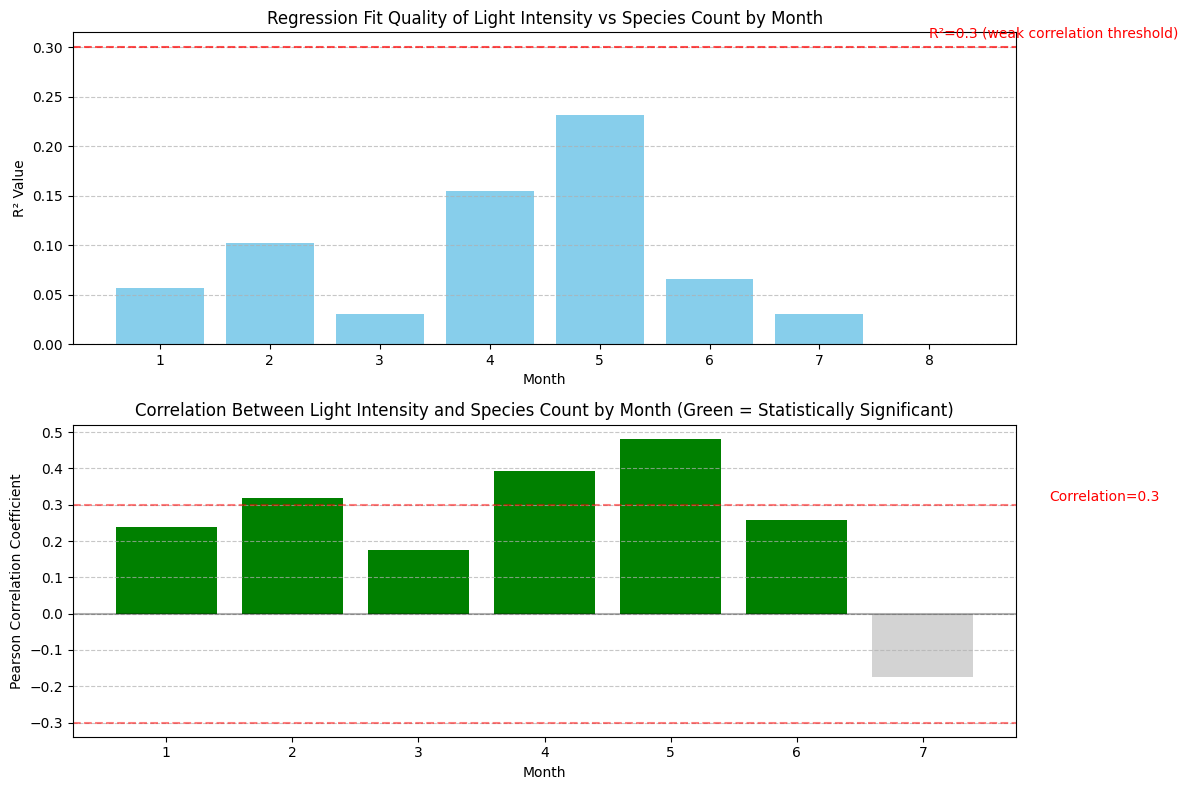

In [49]:
# 按月份进行分组回归分析
print("\nPerforming regression analysis by month...")

monthly_results = []

for month, group in species_with_light.groupby('month'):
    if len(group) < 5:  # 确保有足够的数据点
        print(f"Month {month} has insufficient data points, skipping regression analysis")
        continue

    X_month = group['nsb_matched'].values.reshape(-1, 1)
    y_month = group['species_count'].values  # 修改为正确的列名

    # 创建并拟合线性回归模型
    model_month = LinearRegression()
    model_month.fit(X_month, y_month)

    # 计算模型性能指标
    y_pred_month = model_month.predict(X_month)
    r2_month = r2_score(y_month, y_pred_month)

    # 计算皮尔逊相关系数
    pearson_month, p_value_month = pearsonr(X_month.flatten(), y_month)

    monthly_results.append({
        'month': month,
        'slope': model_month.coef_[0],
        'intercept': model_month.intercept_,
        'r2': r2_month,
        'pearson': pearson_month,
        'p_value': p_value_month,
        'sample_size': len(group)
    })

# 创建月度回归结果数据框
monthly_results_df = pd.DataFrame(monthly_results)
print("\nRegression analysis results by month:")
print(monthly_results_df)

# 可视化月度回归结果
if len(monthly_results_df) > 0:
    plt.figure(figsize=(12, 8))

    # 绘制R²值
    plt.subplot(2, 1, 1)
    plt.bar(monthly_results_df['month'], monthly_results_df['r2'], color='skyblue')
    plt.axhline(y=0.3, color='red', linestyle='--', alpha=0.7)
    plt.text(max(monthly_results_df['month']), 0.31, 'R²=0.3 (weak correlation threshold)', color='red')
    plt.xlabel('Month')
    plt.ylabel('R² Value')
    plt.title('Regression Fit Quality of Light Intensity vs Species Count by Month')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)

    # 绘制相关系数
    plt.subplot(2, 1, 2)
    bars = plt.bar(monthly_results_df['month'], monthly_results_df['pearson'],
                  color=[('green' if x < 0.05 else 'lightgray') for x in monthly_results_df['p_value']])
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.axhline(y=0.3, color='red', linestyle='--', alpha=0.5)
    plt.axhline(y=-0.3, color='red', linestyle='--', alpha=0.5)
    plt.text(max(monthly_results_df['month']), 0.31, 'Correlation=0.3', color='red')
    plt.xlabel('Month')
    plt.ylabel('Pearson Correlation Coefficient')
    plt.title('Correlation Between Light Intensity and Species Count by Month (Green = Statistically Significant)')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig('monthly_regression_results.png')
    plt.show()


In [50]:
# 7. 总结分析结果
print("\n分析总结:")

# 全局相关性分析结果
print(f"1. 整体而言，夜空亮度(NSB)与物种数量的相关系数为 {pearson_corr:.4f}，")
if p_value < 0.05:
    print(f"   这种相关性在统计上是显著的 (p值={p_value:.4f})。")
else:
    print(f"   这种相关性在统计上不显著 (p值={p_value:.4f})。")

# 相关性方向和强度
if pearson_corr > 0:
    direction_desc = "正相关，意味着夜空亮度越高，物种数量也倾向于增加"
else:
    direction_desc = "负相关，意味着夜空亮度越高，物种数量倾向于减少"
print(f"2. 相关性为{direction_desc}。")

# 月度分析结果
if len(monthly_results_df) > 0:
    sig_months = monthly_results_df[monthly_results_df['p_value'] < 0.05]
    if len(sig_months) > 0:
        print(f"3. 在{len(sig_months)}个月份中发现了统计显著的相关性:")
        for _, row in sig_months.iterrows():
            direction = "正" if row['pearson'] > 0 else "负"
            print(f"   - 月份 {row['month']}: {direction}相关 (r={row['pearson']:.4f}, p={row['p_value']:.4f})")
    else:
        print("3. 在按月份分析中，没有发现统计显著的相关性。")

    # 相关性随季节变化趋势
    if len(monthly_results_df) >= 4:
        print("4. 相关性随季节变化的趋势:")
        # 简单地分为四季（根据北半球）
        spring = monthly_results_df[monthly_results_df['month'].isin([3, 4, 5])]['pearson'].mean()
        summer = monthly_results_df[monthly_results_df['month'].isin([6, 7, 8])]['pearson'].mean()
        autumn = monthly_results_df[monthly_results_df['month'].isin([9, 10, 11])]['pearson'].mean()
        winter = monthly_results_df[monthly_results_df['month'].isin([12, 1, 2])]['pearson'].mean()

        print(f"   - 春季 (3-5月): 平均相关系数 = {spring:.4f}")
        print(f"   - 夏季 (6-8月): 平均相关系数 = {summer:.4f}")
        print(f"   - 秋季 (9-11月): 平均相关系数 = {autumn:.4f}")
        print(f"   - 冬季 (12-2月): 平均相关系数 = {winter:.4f}")

# 研究限制
print("\n研究限制:")
print("1. 本分析假设光照强度是影响物种数量的唯一或主要因素，但实际上物种分布受多种因素影响。")
print("2. 克里金插值可能在数据点稀疏的区域产生不准确的估计。")
print("3. 分析未考虑不同物种对光照的不同敏感性。")
print("4. 相关性不等于因果关系，需要更多研究来确定光照与物种数量之间的因果关系。")

print("\n建议:")
print("1. 考虑加入更多环境变量进行多元分析，如温度、降水、人类活动等。")
print("2. 对不同类型的物种（如昼行性vs夜行性）分别进行分析。")
print("3. 增加时间序列分析，研究光照变化对物种数量变化的影响。")
print("4. 在光照强度变化明显的区域进行更密集的采样，以获得更准确的相关性估计。")



分析总结:
1. 整体而言，夜空亮度(NSB)与物种数量的相关系数为 -0.1190，
   这种相关性在统计上是显著的 (p值=0.0001)。
2. 相关性为负相关，意味着夜空亮度越高，物种数量倾向于减少。
3. 在6个月份中发现了统计显著的相关性:
   - 月份 1.0: 正相关 (r=0.2379, p=0.0002)
   - 月份 2.0: 正相关 (r=0.3198, p=0.0001)
   - 月份 3.0: 正相关 (r=0.1753, p=0.0218)
   - 月份 4.0: 正相关 (r=0.3937, p=0.0000)
   - 月份 5.0: 正相关 (r=0.4812, p=0.0000)
   - 月份 6.0: 正相关 (r=0.2568, p=0.0130)
4. 相关性随季节变化的趋势:
   - 春季 (3-5月): 平均相关系数 = 0.3501
   - 夏季 (6-8月): 平均相关系数 = 0.0417
   - 秋季 (9-11月): 平均相关系数 = nan
   - 冬季 (12-2月): 平均相关系数 = 0.2789

研究限制:
1. 本分析假设光照强度是影响物种数量的唯一或主要因素，但实际上物种分布受多种因素影响。
2. 克里金插值可能在数据点稀疏的区域产生不准确的估计。
3. 分析未考虑不同物种对光照的不同敏感性。
4. 相关性不等于因果关系，需要更多研究来确定光照与物种数量之间的因果关系。

建议:
1. 考虑加入更多环境变量进行多元分析，如温度、降水、人类活动等。
2. 对不同类型的物种（如昼行性vs夜行性）分别进行分析。
3. 增加时间序列分析，研究光照变化对物种数量变化的影响。
4. 在光照强度变化明显的区域进行更密集的采样，以获得更准确的相关性估计。
